# Debug the zca whitening

## Load utils

In [1]:
import os
import sys
import time
import inspect
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import timm

from sklearn.cluster import KMeans


CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader
from mosaiks_utils import visualize_3d_patches, visTensor, normalize_patches, DBN

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_image(img, dim=256, ch=3):
    img = img.reshape((dim,dim,ch))
    img_min, img_max = img.min(), img.max()
    plt.imshow((img - img_min) / (img_max - img_min))
    plt.show()

## Load CIFAR10 dataset

In [3]:
trf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=trf)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [4]:
batch = next(iter(trainloader))

(1000, 32, 32, 3)


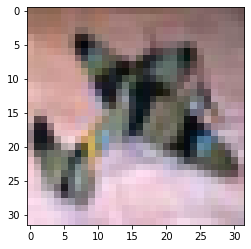

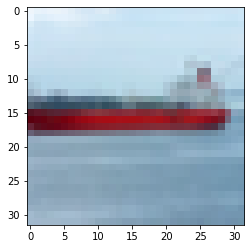

In [5]:
imgs, target = batch

# batch_size = 2
imgs = imgs.numpy().transpose((0,2,3,1))
print(imgs.shape)
show_image(imgs[0], 32)
show_image(imgs[1], 32)

## PCA

In [6]:
imgs.min()

-1.0

In [7]:
# from sklearn.decomposition import PCA
# imgs_pca = imgs.transpose(0,3,1,2).reshape(imgs.shape[0], -1)
# pca = PCA(n_components=400, random_state=0, svd_solver='randomized')
# pca.fit(imgs_pca)

In [8]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.ylim(0.8, 1.0)
# plt.grid()

The 400 components we selected give us ~97% of the "variance explanation". Notice this is just 13% of the number of components in this image (3 channels × 32 × 32 pixels). Images can really be compressed a lot!

We're now going to transform the image using the (truncated) rotation matrix the PCA gave us, then reconstruct the image back and see if there's still a cat in the bag.

In [9]:
# imgs_transformed = np.dot(imgs_pca - pca.mean_, pca.components_.T)

In [10]:
# def reconstruct(pca, vec):
#     return pca.mean_ + np.dot(vec, pca.components_)

# # def vtoimg(v):
# #      return np.array(np.clip(v, 0, 255), dtype=np.uint8).reshape(3,32,32).transpose([1,2,0])
    
# imgs_reconstructed = reconstruct(pca, imgs_transformed[1999])

# # plt.subplot(1,2,1)
# # plt.imshow(red_cat_bag)
# # plt.subplot(1,2,2)
# # plt.imshow(reconstructed_cat)

In [11]:
# show_image(imgs_pca[1999].reshape(3,32,32).transpose(1,2,0), dim=32, ch=3)

In [12]:
# show_image(imgs_reconstructed.reshape(3,32,32).transpose(1,2,0), dim=32, ch=3)

Look at that noisy cat!

So we have now just picked our three-channel images, transformed them into a "shapeless" vector, applied PCA like these were datapoints from any regular classification problem like Iris, and got a basic input vector reconstruction going on. Neat.

## Mosaiks implementation

### ZCA

Now we're going to whiten our signal. We'll just remove that silly mean, and see what's left if we remove the image auto-correlation.

In regular data, the existance of a "principal direction" found by the PCA means your data is correlated. If you rotate the data so that this direction is now an axis, you get a representation where there is no correlation anymore. And if you then appropriately rescale each of these axes, your data is now standardized/normalized/whitened.

In images, if you look for a correlation you'll most probably find auto-correlation. You'll find out each pixel of an image in a set of images is correlated to its neighboring pixels, and they are all correlated like that, relative to each other. It could be something crazy, the top left pixels negativelly correlated to the top right, and the bottom pixels with different autocorrealtion coefficients. But what you usually see, and the simplification you usually impose, is that all pixels share the same auto-correlation function across the image area.

The term "whitening" comes from time-domain processing, it referers to the fact when you remove auto-correlation from the signal, you make it more similar to "white" noise, due to the uniform power spectrum. But notice something: after you change those scales from the rotated pricipal components, the signal phase information is preserved... If you rotate you vector back, then you have a signal that is still decorrelated (distribution of the sample looks like a sphere, not an ellipsoid), but this new transformed signal is somehow as close as possible to the original signal.

Specifically for images this means two things: first you end up kind of making a high-pass filtering, like a Laplacian. Think of the image of a white disc over black background. The decorrelated version is just zero everywhere, when before you had mostly pixels with the same value of their neighbors (correlation). Now you only have pixels around the disk edge... That's where the image infromation is. And you can theoretically even reconstruct the image from this Laplacian version.

The second thing to have in mind about images, is that you also can have different channels... In that case you can also find correlations across the channels. Specially in the RGB color space, this will happen because they share a lot of the luminance information. Spaces like Lab or YUV will separate the luminance, so the correlation across these channels should be a little lower. You usually also find out chrominance channels are more auto-correlated, and for that reason you can usually downsample the chrominance.

So let's calculate some stuff now and see what all that means with graphics. Let's whiten our cat.

In [18]:
zca_bias = 1e-3

In [19]:
zca_bias

0.001

In [20]:
norm_imgs, means, zca_mat = normalize_patches(imgs, zca_bias=zca_bias, whiten=True)

zca bias 0.001
negatives eigen values: (0,)


In [21]:
norm_imgs.shape, zca_mat.shape

((1000, 32, 32, 3), (3072, 3072))

In [22]:
def check_weights(weights_data):
    print(f'min: {weights_data.min()}')
    print(f'max: {weights_data.max()}')
    print(f'mean: {weights_data.mean()}')
    print(f'std: {weights_data.std()}')
    print(f'num_complex numbers: {np.iscomplex(weights_data.sum())}')

In [23]:
check_weights(norm_imgs)

min: -2.509469985961914
max: 2.159900426864624
mean: -1.218790846024831e-09
std: 0.22879596054553986
num_complex numbers: False


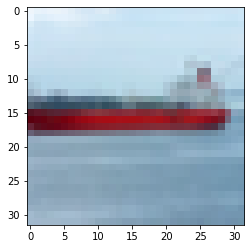

In [24]:
# original image
random_idx = 1
show_image(imgs[random_idx].reshape(32,32,3), 32)

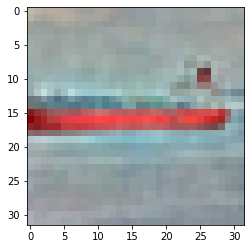

(1000, 32, 32, 3)

In [25]:
# whitened image
show_image(norm_imgs[random_idx].reshape(32,32,3), 32)
norm_imgs.shape

In [26]:
# reconstruct the original image
norm_imgs_flat = norm_imgs.reshape(norm_imgs.shape[0], 32*32*3)

In [27]:
zca_inv = np.linalg.inv(zca_mat)

In [28]:
imgs_reconstructed = np.dot(norm_imgs_flat, zca_inv)

In [29]:
imgs_reconstructed.shape

(1000, 3072)

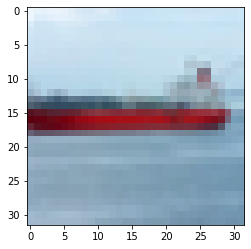

In [30]:
show_image(imgs_reconstructed[random_idx].reshape(32,32,3), 32)

### Covariance matrix of the whitened images

In [31]:
def show_cov_matrix(img_data):
    img_data_flat = img_data.reshape(img_data.shape[0], 32*32*3)
    img_data_cov = (1/img_data.shape[0]) * img_data_flat.T.dot(img_data_flat)
    show_image(np.expand_dims(img_data_cov, 2), 3072, ch=1)
    return img_data_cov

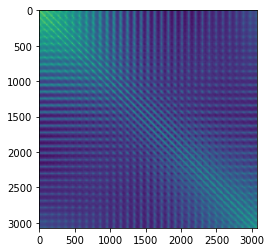

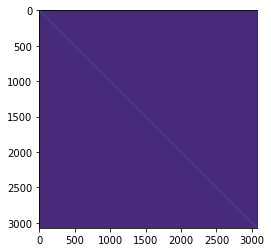

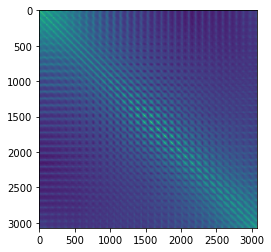

In [114]:
_ = show_cov_matrix(imgs)
    
norm_cov = show_cov_matrix(norm_imgs)
    
_ = show_cov_matrix(imgs_reconstructed)

In [111]:
norm_cov[np.where(norm_cov <= 0.1)] = 0
norm_cov[np.where(norm_cov > 0.1)] = 1
assert  (norm_cov == np.eye(norm_cov.shape[0])).all()

AssertionError: 

In [112]:
norm_cov

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [113]:
for i in range(norm_cov.shape[0]):
    print(norm_cov[i][i])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [23]:
def normalize_patches_2(
    patches, whiten, min_divisor=1e-8, zca_bias=1e-8, mean_rgb=np.array([0, 0, 0])
):
    ''' normalize and whiten a given set of patches
    
    Parameters:
    -----------
    
    patches: ndarray
             array of patches of shape (num_patches, -1)
    
    whiten: bool
            apply whitening
    '''
    if patches.dtype == "uint8":
        patches = patches.astype("float64")
        patches /= 255.0
    
    n_patches = patches.shape[0]
    orig_shape = patches.shape
    patches = patches.reshape(patches.shape[0], -1)
    
    # Zero mean every feature
    means = np.mean(patches, axis=1)
    patches = patches - np.mean(patches, axis=1)[:, np.newaxis]

    # Normalize
    patch_norms = np.linalg.norm(patches, axis=1)

    # Get rid of really small norms
    patch_norms[np.where(patch_norms < min_divisor)] = 1

    # Make features unit norm
    patches = patches / patch_norms[:, np.newaxis]

    if whiten:
        patchesCovMat = (1.0 / n_patches) * patches.T.dot(patches)

        
        (E, V) = np.linalg.eig(patchesCovMat)
        E += zca_bias
        sqrt_zca_eigs = np.sqrt(E)
        inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
        global_ZCA = V.dot(inv_sqrt_zca_eigs).dot(V.T)
#         global_ZCA = V.dot(np.diag(np.sqrt(1/(E + 1e-9)))).dot(V.T)
        patches_normalized = (patches).dot(global_ZCA) #.dot(global_ZCA.T)

        return patches_normalized.reshape(orig_shape), means, global_ZCA
    
    else: # .astype("float32")
        return patches.reshape(orig_shape), None, None

In [24]:
norm_imgs_2, means_2, zca_mat_2 = normalize_patches_2(imgs, whiten=True)

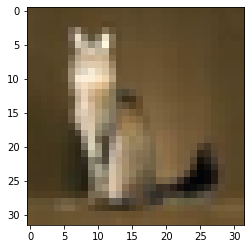

In [25]:
# original image
show_image(imgs[random_idx].reshape(32,32,3), 32)

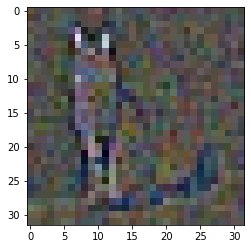

In [26]:
show_image(norm_imgs_2[random_idx].reshape(32,32,3), 32)

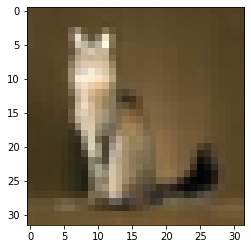

In [27]:
norm_imgs_flat_2 = norm_imgs_2.reshape(norm_imgs_2.shape[0], 32*32*3)
imgs_reconstructed_2 = np.dot(norm_imgs_flat_2, np.linalg.inv(zca_mat_2))
show_image(imgs_reconstructed_2[random_idx].reshape(32,32,3), 32)

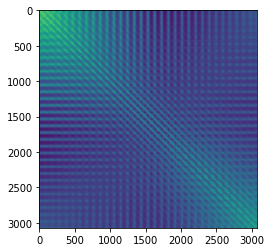

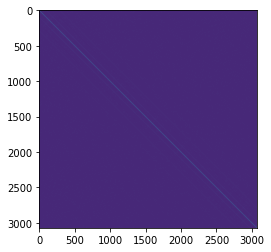

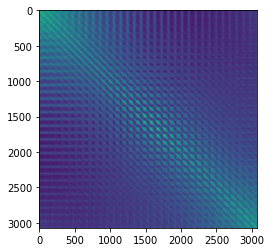

In [28]:
show_cov_matrix(imgs)
    
show_cov_matrix(norm_imgs_2)
    
show_cov_matrix(imgs_reconstructed_2)

## Check the values inside

In [29]:
def check_weights(weights_data):
    print(f'min: {weights_data.min()}')
    print(f'max: {weights_data.max()}')
    print(f'mean: {weights_data.mean()}')
    print(f'std: {weights_data.std()}')
    print(f'num_complex numbers: {np.iscomplex(weights_data).sum()}')

In [30]:
check_weights(imgs_flat)

NameError: name 'imgs_flat' is not defined

In [ ]:
check_weights(norm_imgs_flat)

In [ ]:
check_weights(imgs_reconstructed_flat)